# Getting Started
To get started with `swmmio`, you'll need a EPA SWMM input file (.inp). We'll use an example model provided within `swmmio` and see what it looks like to get a {py:obj}`Model.links <swmmio.core.Model.links>` DataFrame, 

In [3]:
from swmmio.tests.data import MODEL_FULL_FEATURES_PATH
import swmmio

# instantiate a model object
model = swmmio.Model(MODEL_FULL_FEATURES_PATH)

# get the data related to links
model.links.dataframe

,InletNode,OutletNode,...,Barrels,coords
Name,,,,,
C1:C2,J1,J2,...,1.0,"[(0.0, 0.0), (238.75, -53.332)]"
C3,J3,J4,...,NaN,"[(459.058, -113.145), (671.391, -163.985)]"
C2,J2,J3,...,NaN,"[(238.75, -53.332), (459.058, -113.145)]"


## Edit Model Parameters

Now let's use the lower-level {py:obj}`Model.inp <swmmio.core.inp>` API to access and modify the sections of the model. We'll change the outfall type to FIXED and set a stage elevation. 

:::{note}
The {py:class}`Model.inp <swmmio.core.inp>` API has coverage for almost all sections of the INP file. If you find that a section isn't covered that you need, raise an issue [here](https://github.com/pyswmm/swmmio/issues)!
:::

In [2]:
# here is the exsiting outfalls DataFrame
model.inp.outfalls

,InvertElev,OutfallType,StageOrTimeseries
Name,,,
J4,0,FREE,NO


In [3]:
# modify the outfall DataFrame
model.inp.outfalls.loc['J4', 'OutfallType'] = 'FIXED'
model.inp.outfalls.loc['J4', 'StageOrTimeseries'] = 3.0

model.inp.outfalls

,InvertElev,OutfallType,StageOrTimeseries
Name,,,
J4,0,FIXED,3.0


We can then save our updated model to a new .inp file, then instantiate a new {py:class}`~swmmio.core.Model` object. 

In [4]:
model.inp.save('new_model.inp')

# instantiate a new Model object with the modified inp file
new_model = swmmio.Model('new_model.inp')

# see the changes in the higher-level nodes DataFrame
new_model.nodes.dataframe 

,InvertElev,MaxDepth,...,EvapFrac,coords
Name,,,,,
J1,20.728,15.0,...,NaN,"[(0.0, 0.0)]"
J3,6.547,15.0,...,NaN,"[(459.058, -113.145)]"
J4,0.000,NaN,...,NaN,"[(671.391, -163.985)]"
J2,13.392,NaN,...,0.0,"[(238.75, -53.332)]"


## Building Variations of Models
Starting with a base SWMM model, other models can be created by inserting altered data into a new inp file. Useful for sensitivity analysis or varying boundary conditions, models can be created using a fairly simple loop.

For example, climate change impacts can be investigated by creating a set of models with varying outfall Fixed Stage elevations:


In [5]:
import os

# path to a SWMM model from swmm-nrtestsuite
model_path = 'https://raw.githubusercontent.com/USEPA/swmm-nrtestsuite/refs/heads/dev/public/examples/Example3.inp'

# initialize a baseline model object
baseline = swmmio.Model(model_path)

rise = 0.0 # set the starting sea level rise condition

# set the outfall type and initial outfall stage elevation
baseline.inp.outfalls.loc[:, 'OutfallType'] = 'FIXED'
baseline.inp.outfalls.loc[:, 'StageOrTimeseries'] = 576

# create models up to 5ft of sea level rise.
while rise <= 5:

    # create a dataframe of the model's outfalls
    outfalls = baseline.inp.outfalls

    # add the current rise to the outfalls' stage elevation
    outfalls.loc[:, 'StageOrTimeseries'] = outfalls.loc[:, 'StageOrTimeseries'] + rise
    baseline.inp.outfalls = outfalls
    
    # create the filename for the new model
    newfilepath = os.path.join(baseline.inp.dir, f'{baseline.inp.name}_{rise}_SLR.inp')
    
    # Overwrite the OUTFALLS section of the new model with the adjusted data
    baseline.inp.save(newfilepath)

    # increase sea level rise for the next loop
    rise += 0.25

# check the outfalls of the last SLR scneario
model = swmmio.Model(newfilepath)
model.inp.outfalls

,InvertElev,OutfallType,StageOrTimeseries
Name,,,
KRO2005,574.32,FIXED,628.5
PSO,548.36,FIXED,628.5


## Nodes and Links
Specific sections of data from the inp and rpt can be extracted with `Nodes` and `Links` objects. Although these are the same object-type of the {py:meth}`swmmio.core.Model.nodes` and {py:meth}`swmmio.core.Model.links`, accessing them directly allows for custom control over what sections of data are retrieved. 

In [ ]:
from swmmio import Model, Nodes
m = Model(model_path)

# pass custom init arguments into the Nodes object instead of using default settings referenced by m.nodes() 
nodes = Nodes(
    model=m, 
    inp_sections=['junctions', 'storage', 'outfalls'],
    rpt_sections=['Node Depth Summary', 'Node Inflow Summary'],
    columns=[ 'InvertElev', 'MaxDepth', 'InitDepth', 'SurchargeDepth', 'MaxTotalInflow', 'coords']
)

# access data 
nodes.geodataframe.head()

,InvertElev,MaxDepth,InitDepth,SurchargeDepth,geometry
Name,,,,,
KRO3001,556.19,10.0,0.0,0.0,POINT (1362408.25 431113.81)
KRO6015,585.98,8.0,0.0,0.0,POINT (1362748.63 428675.19)
KRO6016,584.14,9.0,0.0,0.0,POINT (1362767 428813.59)
KRO6017,582.01,14.0,0.0,0.0,POINT (1363087.25 428778.19)
KRO1002,594.89,3.0,0.0,0.0,POINT (1362361.78 429189.37)


## Access Model Network as Graph
The {py:obj}`~swmmio.core.Model` class returns a Networkx MultiDiGraph representation of the model via that {py:meth}`Model.network <swmmio.core.Model.network>` parameter:

In [ ]:
# access the model as a Networkx MutliDiGraph
model = Model(model_path)
G = model.network

# iterate through links
for u, v, key, data in model.network.edges(data=True, keys=True):
    # do stuff with the network
    print(u, v, key, data)
    break


KRO3001 SU1 KRO3001-KRO3002 {'Length': 176.7171053, 'Roughness': 0.013, 'InOffset': 0.0, 'OutOffset': 5.0, 'InitFlow': 0.0, 'PumpCurve': nan, 'InitStatus': nan, 'Shape': 'CIRCULAR', 'Geom1': 1.0, 'Geom2': 0.0, 'Geom3': 0.0, 'Geom4': 0.0, 'Barrels': 1.0, 'coords': [(np.float64(1362408.25), np.float64(431113.81)), (np.float64(1362652.04), np.float64(431078.91))], 'facilityid': 'KRO3001-KRO3002', 'geometry': {"coordinates": [[1362408.25, 431113.81], [1362652.04, 431078.91]], "type": "LineString"}}


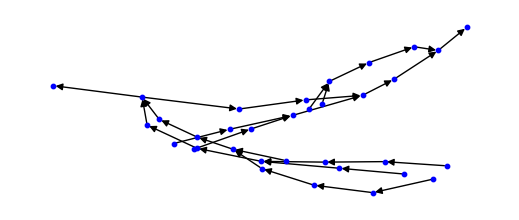

In [ ]:
# visualize the graph
import matplotlib.pyplot as plt
import networkx as nx
# Draw the graph
pos = nx.spring_layout(G, k=30)

plt.figure(figsize=(5, 2))
nx.draw(G, node_size=10, node_color='blue', with_labels=False)
plt.show()

For a more interesting example takes advantage of the graph-representation of a model, see [Visualizing SWMM Models](visualizing_models.ipynb). 

## Running Models
Using the command line tool, individual SWMM5 models can be run by invoking the swmmio module in your shell as such:
```shell
python -m swmmio --run path/to/mymodel.inp
```
If you have many models to run and would like to take advantage of your machine's cores, you can start a pool of simulations with the `--start_pool` (or `-sp`) command. After pointing `-sp` to one or more directories, swmmio will search for SWMM .inp files and add all them to a multiprocessing pool. By default, `-sp` leaves 4 of your machine's cores unused. This can be changed via the `-cores_left` argument.
```shell
# run all models in models in directories Model_Dir1 Model_Dir2
python -m swmmio -sp Model_Dir1 Model_Dir2  

# leave 1 core unused
python -m swmmio -sp Model_Dir1 Model_Dir2  -cores_left=1
```

:::{warning}
Using all cores for simultaneous model runs can put your machine's CPU usage at 100% for extended periods of time. This probably puts stress on your hardware. Use at your own risk.
:::
